In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
'''import sys 
#sys.path.append("C://Users//saika//Downloads")
sys.path.append("C://Users//saika//OneDrive//Documents//LSMMData-main (2)//LSMMData-main//src//lsmm_data")'''

'import sys \n#sys.path.append("C://Users//saika//Downloads")\nsys.path.append("C://Users//saika//OneDrive//Documents//LSMMData-main (2)//LSMMData-main//src//lsmm_data")'

In [3]:
#pip install update lsmm_data-0.0.6-py2.py3-none-any.whl

In [4]:
from lsmm_data import LSMMData
import json

with open('all_cells_proofread_connectome.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']
#print("Connectome Index.  Should be 41:", mappings['pt_root_id_to_connectome_index'][pt_root_id])


Generating Connectome...


100%|██████████| 137706/137706 [00:16<00:00, 8188.68it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:22<00:00, 6036.46it/s]


     level_0  index      id          pt_root_id  pt_position_x  pt_position_y  \
0         11   5343  265264  864691132808934303         760014         425481   
1         13   5341  265634  864691132732388891         736114         457840   
2         22   5267  265622  864691132690646038         882079         467618   
3         31    889  266587  864691132731513964         803393         444648   
4         41   5609  341272  864691132661462205         922664         410814   
..       ...    ...     ...                 ...            ...            ...   
847     8796   6024  274993  864691132618678215         832726         518601   
848     8797   2948  265362  864691132785809960         870672         457142   
849     8799   6362  294211  864691132653001075         825664         647572   
850     8804   1139  265241  864691132634898417         731225         334844   
851     8805   8393  264864  864691132893609430         750625         340897   

     pt_position_z classifi

In [5]:
'''---------------------When using LSMM-------------------------------------'''
cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']

# # # cell_table = cell_table.query('soma_layer == "23"')[['pt_root_id', 'soma_layer']].reset_index()
# #cell_table['connectome_index'] = cell_table['conn']

# # cell_table['connectome_index'] = cell_table.index
# # cell_table = cell_table.query('cell_type == "PYC"')[['connectome_index', 'pt_root_id', 'soma_layer']].reset_index()

# synapse_table = tables['structural']['synapse'] #pandas.read_feather('C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather')
# weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)
# adjacency_matrix = weight_matrix.clip(0,1)
# np.fill_diagonal(weight_matrix, 0)
# #pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

In [6]:
#new_synapse_plus_cell_table = pandas.read_feather("C://Users//saika//Downloads//Assembly_paper//949//synapses_v1dd_742_combined_incl_trafo_241218.feather")

In [7]:
#new_synapse_plus_cell_table.keys()

In [8]:
#new_synapse_plus_cell_table

In [9]:
#new_cell_annos = pandas.read_feather("C://Users//saika//Downloads//Assembly_paper//coregistration_table_19thDec.feather")

In [10]:
#new_cell_annos

In [11]:
tables['structural']['summed_size_connectome']

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0., 2212.],
       [   0.,    0.,    0., ...,    0.,  290.,    0.]])

In [12]:
'''###NOT NEEDED IN LATEST VERSION
def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()

    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
    return synapse_connectome'''

"###NOT NEEDED IN LATEST VERSION\ndef calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):\n    pre_cell_pt_index = pre_cells['pt_root_id']\n    post_cell_pt_index = post_cells['pt_root_id']\n    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]\n    pre_cell_pt_index = pre_cell_pt_index.to_list()\n    post_cell_pt_index = post_cell_pt_index.to_list()\n\n    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))\n    for synapse in tqdm(range(len(synapses))):\n        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])\n        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])\n        if use_sizes:\n            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']\n        else:\n            synapse_connectome[preidx,postidx] += 1\n    return synapse_connectome"

In [13]:
#synapse_table_old_ref = pandas.read_feather('C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather')

In [14]:
#synapse_table_old_ref

In [15]:
# cell_table = new_cell_annos
# synapse_table = new_synapse_plus_cell_table
# weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)

In [16]:

'''cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']

# # # cell_table = cell_table.query('soma_layer == "23"')[['pt_root_id', 'soma_layer']].reset_index()
# #cell_table['connectome_index'] = cell_table['conn']

# # cell_table['connectome_index'] = cell_table.index
# # cell_table = cell_table.query('cell_type == "PYC"')[['connectome_index', 'pt_root_id', 'soma_layer']].reset_index()

# synapse_table = tables['structural']['synapse'] #pandas.read_feather('C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather')
# weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)
# adjacency_matrix = weight_matrix.clip(0,1)
# np.fill_diagonal(weight_matrix, 0)
# #pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)'''

'cell_table = tables[\'structural\'][\'pre_cell\']\n\nweight_matrix = tables[\'structural\'][\'summed_size_connectome\']\n\n# # # cell_table = cell_table.query(\'soma_layer == "23"\')[[\'pt_root_id\', \'soma_layer\']].reset_index()\n# #cell_table[\'connectome_index\'] = cell_table[\'conn\']\n\n# # cell_table[\'connectome_index\'] = cell_table.index\n# # cell_table = cell_table.query(\'cell_type == "PYC"\')[[\'connectome_index\', \'pt_root_id\', \'soma_layer\']].reset_index()\n\n# synapse_table = tables[\'structural\'][\'synapse\'] #pandas.read_feather(\'C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather\')\n# weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)\n# adjacency_matrix = weight_matrix.clip(0,1)\n# np.fill_diagonal(weight_matrix, 0)\n# #pyr_graph = nx.from_num

In [17]:
mappings.keys()

dict_keys(['functional_indexes_by_assembly', 'assemblies_by_functional_index', 'pt_root_id_to_connectome_index', 'connectome_index_to_root_id', 'pt_root_id_to_post_connectome_index', 'post_connectome_index_to_root_id', 'roi_id_to_pt_root_id', 'pt_root_id_to_roi_id', 'roi_id_to_functional_index', 'functional_index_to_roi_id', 'assemblies_by_roi_id', 'assemblies_by_pt_root_id', 'assemblies_by_connectome_index', 'assemblies_by_post_connectome_index', 'connectome_indexes_by_assembly', 'post_connectome_indexes_by_assembly', 'pt_root_ids_by_assembly', 'roi_ids_by_assembly'])

In [18]:
cell_table

,level_0,index,id,pt_root_id,pt_position_x,pt_position_y,pt_position_z,classification_system,cell_type,status_axon,...,dist_pia,dist_1-23,dist_23-4,dist_4-5,dist_5-6,dist_WM,full_dendrite,cell_type_v2,connectome_index,pt_position
0,11,5343,265264,864691132808934303,760014,425481,215010,excitatory,2P,extended,...,78451.622596,21548.377404,191548.377404,321548.377404,471548.377404,671548.377404,False,2P,0,"[760014, 425481, 215010]"
1,13,5341,265634,864691132732388891,736114,457840,250740,excitatory,2P,extended,...,119312.651378,19312.651378,150687.348622,280687.348622,430687.348622,630687.348622,True,2P,1,"[736114, 457840, 250740]"
2,22,5267,265622,864691132690646038,882079,467618,238860,excitatory,2P,extended,...,124827.038258,24827.038258,145172.961742,275172.961742,425172.961742,625172.961742,True,2P,2,"[882079, 467618, 238860]"
3,31,889,266587,864691132731513964,803393,444648,325080,excitatory,2P,extended,...,126167.019230,26167.019230,143832.980770,273832.980770,423832.980770,623832.980770,True,2P,3,"[803393, 444648, 325080]"
4,41,5609,341272,864691132661462205,922664,410814,320310,excitatory,2P,extended,...,91697.627079,8302.372921,178302.372921,308302.372921,458302.372921,658302.372921,True,2P,4,"[922664, 410814, 320310]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,8796,6024,274993,864691132618678215,832726,518601,120330,inhibitory,SparTC,extended,...,142465.853582,42465.853582,127534.146418,257534.146418,407534.146418,607534.146418,True,SparTC-L23,847,"[832726, 518601, 120330]"
848,8797,2948,265362,864691132785809960,870672,457142,212535,inhibitory,SparTC,extended,...,107743.462239,7743.462239,162256.537761,292256.537761,442256.537761,642256.537761,True,SparTC-L23,848,"[870672, 457142, 212535]"
849,8799,6362,294211,864691132653001075,825664,647572,260595,inhibitory,SparTC,extended,...,304310.530485,204310.530485,34310.530485,95689.469515,245689.469515,445689.469515,True,SparTC-L4,849,"[825664, 647572, 260595]"
850,8804,1139,265241,864691132634898417,731225,334844,214425,inhibitory,SparTC,extended,...,8889.854477,108889.854477,278889.854477,408889.854477,558889.854477,758889.854477,True,SparTC-NOL,850,"[731225, 334844, 214425]"


In [19]:
cell_table.keys()

Index(['level_0', 'index', 'id', 'pt_root_id', 'pt_position_x',
       'pt_position_y', 'pt_position_z', 'classification_system', 'cell_type',
       'status_axon', 'pt_position_x_trafo', 'pt_position_y_trafo',
       'pt_position_z_trafo', 'layer', 'dist_pia', 'dist_1-23', 'dist_23-4',
       'dist_4-5', 'dist_5-6', 'dist_WM', 'full_dendrite', 'cell_type_v2',
       'connectome_index', 'pt_position'],
      dtype='object')

In [20]:
'''when using LSMM'''
l1 = cell_table.query('layer  == "L1"')
l23 = cell_table.query('layer  == "L23"')
l4 = cell_table.query('layer  == "L4"')
l5 = cell_table.query('layer  == "L5"')
l6 = cell_table.query('layer  == "L6"')


In [21]:
for idx, sublist in enumerate(l1['pt_position_y_trafo']):
     pos2 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
     print(pos2)

79799.64946418333
93379.3723602891
87750.19411825408
100076.99956833453
99175.15719302866
95874.69079827287
95104.47333817104
96612.73911140962
89018.20228430603
65638.75609179967
101590.96128348052
66292.69511314102
69780.99590217021
101811.0352156487
61105.14227848984
7719.367638640394
37917.882306254374
99838.77883754131
55894.26386791371
39898.780937435244
66177.22047347222
90589.10397215401
58961.99880086941
85954.93878029182
25903.39012702956
59390.9013318725
100855.89480013207
34394.087257864776
65192.63637324484
23087.659459281156
75481.37106285749
5830.406338428686
65592.19688795751
69995.44465419816
68549.42047879384
83819.7271757146
38328.84109988064
28519.937599981113
45349.79481681152
30886.232349149283
43268.32253312591
71061.06565542793


In [22]:
max_p2_l1 = float('-inf')
for idx, sublist in enumerate(l1['pt_position_y_trafo']):
    pos2 = sublist/1000  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l1:
        max_p2_l1 = pos2
print("L1:", max_p2_l1)

max_p2_l23 = float('-inf')
for idx, sublist in enumerate(l23['pt_position_y_trafo']):
    pos2 = sublist/1000  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l23:
        max_p2_l23 = pos2
print("L23:",max_p2_l23)

max_p2_l4 = float('-inf')
for idx, sublist in enumerate(l4['pt_position_y_trafo']):
    pos2 = sublist/1000 # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l4:
        max_p2_l4 = pos2
print("L4:",max_p2_l4)

max_p2_l5 = float('-inf')
for idx, sublist in enumerate(l5['pt_position_y_trafo']):
    pos2 = sublist/1000  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l5:
        max_p2_l5 = pos2
print("L5:",max_p2_l5)

max_p2_l6 = float('-inf')
for idx, sublist in enumerate(l6['pt_position_y_trafo']):
    pos2 = sublist/1000  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    if pos2 > max_p2_l6:
        max_p2_l6 = pos2
print("L6:",max_p2_l6)

L1: 101.8110352156487
L23: 274.9746804750402
L4: 407.5061989400466
L5: 570.16040905315
L6: 789.1471150522766


In [23]:
max_p2_l1

101.8110352156487

In [24]:
'''coords = np.load("C://Users//saika//Downloads//transformed_coordinates.npy")'''

'coords = np.load("C://Users//saika//Downloads//transformed_coordinates.npy")'

In [25]:
'''for idx,connections  in enumerate(coords):
    print(connections)'''

'for idx,connections  in enumerate(coords):\n    print(connections)'

In [26]:
weight_matrix

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0., 2212.],
       [   0.,    0.,    0., ...,    0.,  290.,    0.]])

In [27]:
#checking psd sizes
summed_psd_size = []
for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        summed_psd_size.append(conn_value)

In [28]:
np.max(summed_psd_size)

53280.0

cell_table


In [29]:
np.max(weight_matrix)

53280.0

In [30]:
'''for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        print(conn_idx, conn_value)'''

'for idx,connections  in enumerate(weight_matrix):\n    for conn_idx,conn_value in enumerate(connections):\n        print(conn_idx, conn_value)'

In [31]:
import matplotlib as mpl

def colorFader(c1, c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [32]:
for idx, pos1, pos2 in zip(cell_table['connectome_index'], cell_table['pt_position_x_trafo'], cell_table['pt_position_y_trafo']):
   # pos1, pos2, pos3 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    # pos1_rounded = round(pos1, 2)
    # pos2_rounded = round(pos2, 2)
    pos = [pos1/1000, pos2/1000]
    print(pos)

[-112.82482059262179, 79.79964946418333]
[-137.62010666309936, 121.81176783681819]
[8.244210699271779, 127.49201808851116]
[-70.52536375089414, 128.8721844861062]
[49.53843459830524, 93.3793723602891]
[-67.93367274880269, 87.75019411825407]
[49.51563002362865, 152.57149622363582]
[-63.69985788749028, 100.07699956833453]
[-156.91928895355613, 110.07302286978202]
[-126.97422435653003, 99.17515719302865]
[-124.05107077711318, 140.40938200416468]
[-79.49789244569183, 133.19172626108934]
[-14.230543941288502, 111.63095565176725]
[-9.374577514134216, 121.25354980710593]
[-10.587800146633294, 126.48616069415569]
[2.5282465210887053, 167.40085505733944]
[-117.17949161230206, 128.19269411962944]
[-32.8992366712639, 95.87469079827288]
[-137.82195442776742, 95.10447333817103]
[3.3874662988721496, 168.03306166637614]
[-14.16450439465848, 135.3452694657709]
[9.74361377320393, 108.77856654479528]
[-7.400232518412984, 108.53921010930189]
[-68.97440501274616, 124.697791055161]
[-125.25286147158145, 14

In [33]:

c1 = "#F6E96B"
c2 = "#387F39"

# alt1 = "#5fa7c8"
# alt2 = "#c85fa7"

# c1 = alt1
# c2 = alt2
G = nx.Graph()

for idx, pos1, pos2 in zip(cell_table['connectome_index'], cell_table['pt_position_x_trafo'], cell_table['pt_position_y_trafo']):
   # pos1, pos2, pos3 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    # pos1_rounded = round(pos1, 2)
    # pos2_rounded = round(pos2, 2)
    G.add_node(idx, pos = [pos1/1000, pos2/1000])  

alpha_vals = []
for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        if 15000 < conn_value <= 18000:
            G.add_edge(idx,conn_idx, weight = 1, color = colorFader(c1, c2, 0),  label='Connection 1')   #[weights_old: 0.2, 0.8, 1.2, 2] #too much to scale by 10
            if G.has_edge(idx, conn_idx):
             
             alpha_vals.append(1)
            else:
                 print(f"Failed to add edge ({idx}, {conn_idx})")
        elif 18000 < conn_value <= 30000:
            G.add_edge(idx,conn_idx, weight = 2, color = colorFader(c1, c2, 0.8/4), alpha = 0.05,label='Connection 2')
            if G.has_edge(idx, conn_idx):
             alpha_vals.append(1)
        elif 30000 < conn_value <= 45000:
            G.add_edge(idx,conn_idx, weight = 2, color = colorFader(c1, c2, 2.5/4), alpha = 0.25, label='Connection 3')
            if G.has_edge(idx, conn_idx):
             alpha_vals.append(1)
        elif conn_value> 45000:
            G.add_edge(idx,conn_idx, weight = 2, color = colorFader(c1, c2, 5/4), label='Connection 4')
            if G.has_edge(idx, conn_idx):
             alpha_vals.append(1)
           # alpha_vals.append(1)
   # if idx>0:
   #     G.add_edge(idx-1, idx)  # Adding edge between consecutive nodes




In [34]:
len(alpha_vals)

381

In [35]:
colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()


In [36]:
color_map = []
marker_list = []
assembly_map = []
idx = []
node_size_list = []
coregistered_node_size_list = []
coregistered_nodes = []
non_co_registered_nodes = []
non_coregistered_node_size_list = []
z_order_values = []
no_assembly = ['No A']
for node in G.nodes():
   if cell_table['classification_system'][node] == 'inhibitory':
                            #print(nik)
                            color_map.append('grey')
                            marker_list.append('o')
                            node_size_list.append(370)
                            z_order_values.append(1)
                           # edge_color.append('none')

                            
            
            #idx.append(node)
   elif cell_table['classification_system'][node] == 'excitatory':
      
    
        if node in  mappings['assemblies_by_connectome_index'].keys():
                   val = mappings['assemblies_by_connectome_index'][node]
                   if val == no_assembly:
                         
                         # color_map[node] = 'maroon'
                          color_map.append('maroon')
                          marker_list.append('^')
                          node_size_list.append(700)
                          z_order_values.append(4)
                          #assembly_map.append('black')
                   else:
                            #print(nik)
                            color_map.append('royalblue')
                            marker_list.append('^')
                            node_size_list.append(700)
                            z_order_values.append(4)
                           # edge_color.append('none')
        else:
            color_map.append('grey')
            marker_list.append('^')
            node_size_list.append(530)
            z_order_values.append(1)
            #idx.append(node)


In [37]:
mappings['assemblies_by_connectome_index']

{73: ['A 1'],
 79: ['A 1', 'A 9'],
 102: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'],
 217: ['A 1'],
 119: ['A 1', 'A 5', 'A 7', 'A 10'],
 161: ['A 1', 'A 3'],
 189: ['A 1'],
 53: ['A 1'],
 204: ['A 1'],
 170: ['A 1', 'A 4', 'A 7', 'A 8'],
 213: ['A 1', 'A 4', 'A 7', 'A 8'],
 98: ['A 1', 'A 2', 'A 8'],
 183: ['A 1', 'A 2', 'A 10'],
 171: ['A 1', 'A 3'],
 132: ['A 1'],
 159: ['A 1', 'A 3', 'A 5'],
 140: ['A 1', 'A 2', 'A 3'],
 44: ['A 1', 'A 2', 'A 6'],
 156: ['A 1'],
 203: ['A 1', 'A 4'],
 245: ['A 1'],
 233: ['A 1'],
 94: ['A 1', 'A 6'],
 246: ['A 1'],
 254: ['A 1', 'A 9', 'A 14'],
 196: ['A 1', 'A 3', 'A 4'],
 143: ['A 1', 'A 2', 'A 9'],
 249: ['A 1', 'A 2'],
 255: ['A 1'],
 55: ['A 1', 'A 6'],
 269: ['A 1', 'A 6'],
 265: ['A 1'],
 243: ['A 1', 'A 4', 'A 7'],
 181: ['A 1', 'A 3', 'A 8'],
 242: ['A 1'],
 175: ['A 2'],
 198: ['A 2', 'A 11'],
 160: ['A 2'],
 117: ['A 2', 'A 10'],
 251: ['A 2', 'A 3', 'A 4', 'A 5'],
 232: ['A 2', 'A 10'],
 65: ['A 3'],
 99: ['A 3', 'A 7', 'A 8'],
 58: ['A

In [38]:
G.edges()

EdgeView([(0, 12), (0, 636), (2, 648), (2, 680), (3, 657), (3, 664), (4, 640), (5, 636), (5, 644), (6, 321), (7, 574), (10, 668), (11, 680), (12, 526), (12, 665), (16, 636), (16, 670), (18, 672), (18, 636), (19, 644), (20, 333), (21, 471), (21, 678), (22, 39), (23, 657), (24, 668), (25, 206), (26, 323), (26, 641), (27, 36), (28, 648), (28, 657), (30, 640), (31, 462), (31, 36), (31, 636), (33, 657), (33, 664), (34, 664), (35, 322), (35, 574), (35, 665), (36, 466), (36, 680), (38, 336), (39, 636), (48, 72), (61, 465), (70, 325), (70, 341), (72, 649), (75, 329), (82, 341), (98, 535), (108, 652), (114, 691), (128, 535), (130, 732), (133, 522), (133, 695), (133, 696), (146, 681), (151, 700), (152, 192), (155, 341), (157, 646), (160, 708), (167, 647), (172, 333), (177, 658), (179, 681), (183, 341), (183, 683), (185, 333), (192, 327), (192, 345), (201, 681), (202, 652), (205, 330), (232, 522), (240, 717), (299, 551), (320, 553), (320, 558), (320, 719), (320, 741), (320, 753), (320, 763), (320

In [39]:
pos = nx.get_node_attributes(G, 'pos')


In [40]:
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch
import matplotlib as mpl


In [41]:
##TRIAL FIGURE
'''
fig, ax = plt.subplots()



nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=4,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis



# Create custom legend handles for nodes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Non-assembly cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=10, label='Unregistered cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='green', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='b', markersize=10, label='Non-assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='y', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='m', markersize=10, label='Non-assembly cells')
]

# Add the legend to the plot
node_legend = ax.legend(handles=legend_elements, loc='upper left')

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color='lightgreen', lw=0.5),
    Line2D([0], [0], color='b', lw=1),
    Line2D([0], [0], color='y', lw=1.5),
    Line2D([0], [0], color='m', lw=2)
]

# Add the legend to the plot
edge_legend = ax.legend(handles=edge_legend_elements, loc='lower right', title='Synapse strength: low to high',title_fontsize = 6.5, bbox_to_anchor=(1, 0))

# Show the plot
#ax.invert_yaxis()
ax.add_artist(node_legend)  # Add the node legend first
ax.add_artist(edge_legend)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.xlabel('pt position X')
plt.ylabel('pt position Y')
plt.title('Connectome Network')
plt.show()'''

"\nfig, ax = plt.subplots()\n\n\n\nnx.draw(G, pos,\n        width=list(weights),\n        edge_color=colors, \n        with_labels=False,node_size=4,\n        node_color=color_map, ax= ax)\nlimits=plt.axis('on') # turns on axis\n\n\n\n# Create custom legend handles for nodes\nlegend_elements = [\n    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Assembly cells'),\n    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Non-assembly cells'),\n    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=10, label='Unregistered cells'),\n    # Line2D([0], [0], marker='_', color='w', markerfacecolor='green', markersize=10, label='Assembly cells'),\n    # Line2D([0], [0], marker='_', color='w', markerfacecolor='b', markersize=10, label='Non-assembly cells'),\n    # Line2D([0], [0], marker='_', color='w', markerfacecolor='y', markersize=10, label='Assembly cells'),\n    # Line2D([0], [0], mark

In [42]:

c1 = "#F6E96B"
c2 = "#387F39"

# alt1 = "#5fa7c8"
# alt2 = "#c85fa7"

# c1 = alt1
# c2 = alt2
G = nx.Graph()

for idx, pos1, pos2 in zip(cell_table['connectome_index'], cell_table['pt_position_x_trafo'], cell_table['pt_position_y_trafo']):
   # pos1, pos2, pos3 = sublist  # Unpack the elements in the sublist #use co-ordinates from tables and check if pt_root_id matches
    # pos1_rounded = round(pos1, 2)
    # pos2_rounded = round(pos2, 2)
    G.add_node(idx, pos = [pos1/1000, pos2/1000])  

alpha_vals = []
for idx,connections  in enumerate(weight_matrix):
    for conn_idx,conn_value in enumerate(connections):
        if conn_value >= 15000:
         
            G.add_edge(idx,conn_idx, weight = 2, color = colorFader(c1, c2, 0.8/4), alpha = 0.25, label='Connection 3')
            if G.has_edge(idx, conn_idx):
             alpha_vals.append(1)
       

colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()

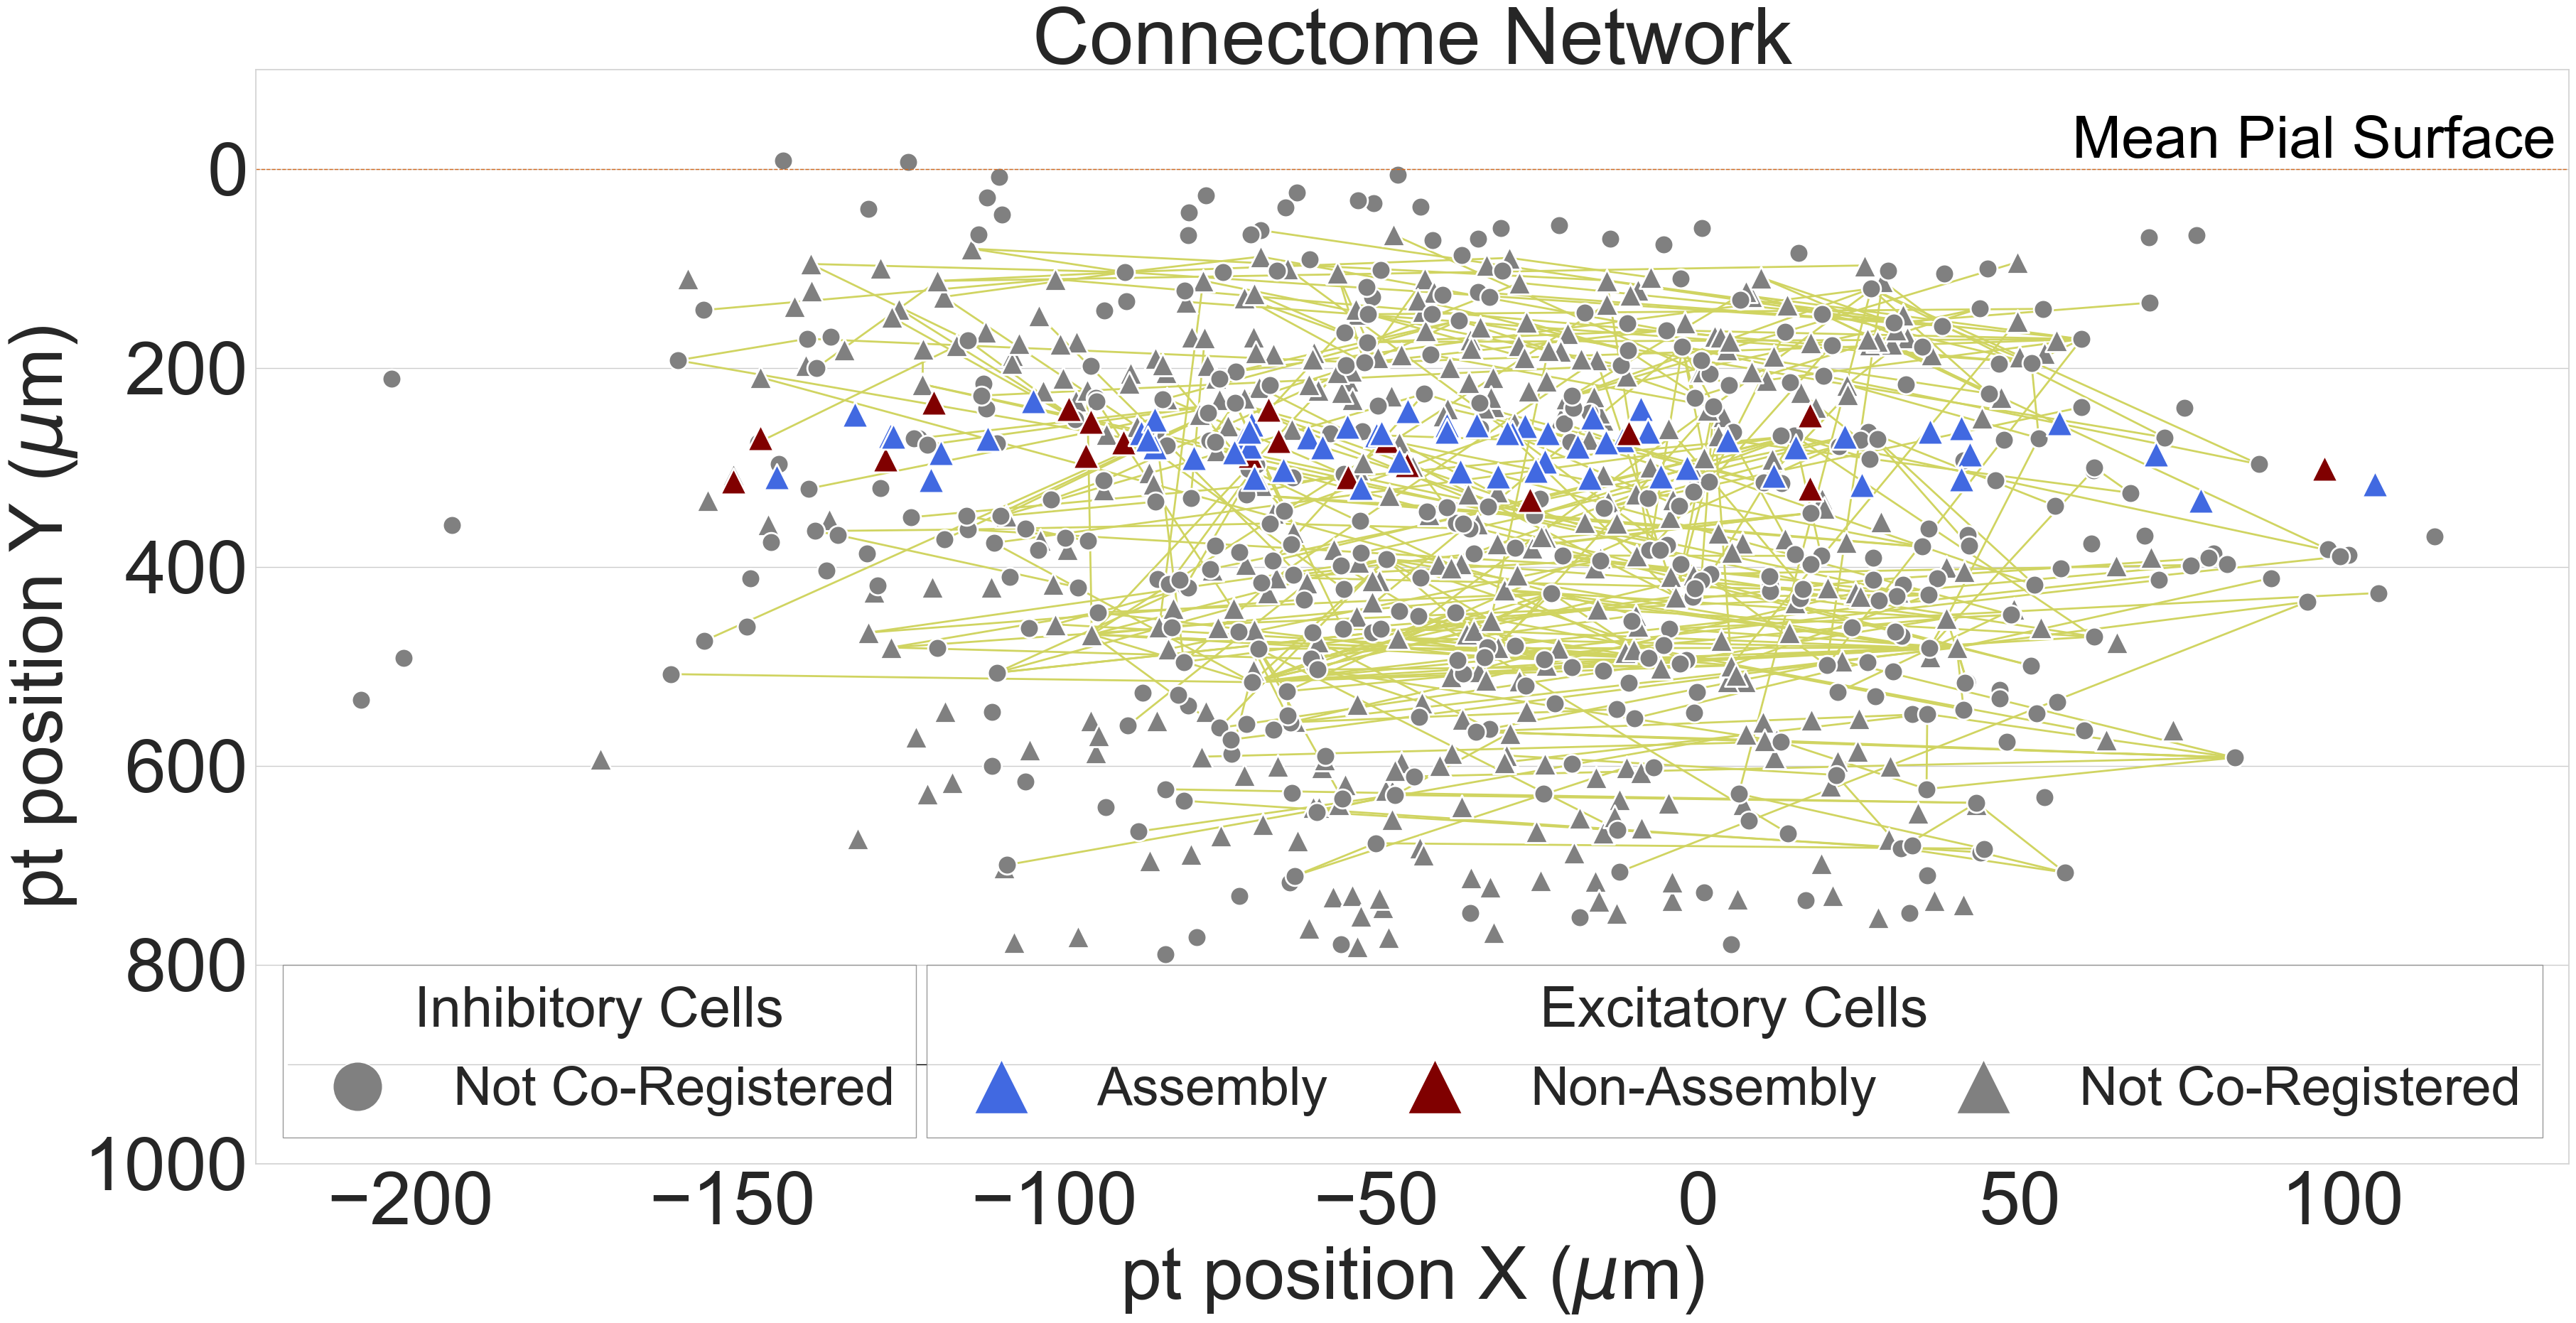

In [50]:

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(42,20))


nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=0,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis

for i, node in enumerate(G.nodes()):
    node_artist = nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=[color_map[i]], 
                           node_size=node_size_list[i], node_shape=marker_list[i],edgecolors= "white",linewidths= 2,  ax=ax) #  markeredgewidth=2, markeredgecolor='white', zorder=2 )
    
    node_artist.set_zorder(z_order_values[i])

# nx.draw_networkx_nodes(G, pos, nodelist=nodes_to_back, node_color="lightblue", node_size=700, zorder=1)  # Back nodes
# nx.draw_networkx_nodes(G, pos, nodelist=nodes_to_front, node_color="orange", node_size=700, zorder=2)  # Front nodes

#-------Add layers to plot----------
#y_values = [max_p2_l1, max_p2_l23,max_p2_l4,  max_p2_l5,  max_p2_l6]
y_values= [100, 270, 400,  550, 750]
#labels = ['Layer 1', 'Layer 23', 'Layer 4', 'Layer 5', 'Layer 6']
#ax.collections[0].set_edgecolor("red") 
ax.axhline(y=0, color='chocolate', linestyle='--', linewidth=1)
    #x = ax.get_x()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
offset = 2
ax.text(x_max - offset, 0 , s = 'Mean Pial Surface', color='black', fontsize=60, ha='right', va='bottom')

ax = plt.gca()



#---------------------------------


# # Create custom legend handles for nodes
legend_element1 = [
   
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=50, label='Not Co-Registered')]

legend_element2 = [    
    Line2D([0], [0], marker='^', color='w', markerfacecolor='royalblue', markersize=55, label='Assembly'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='maroon', markersize=55, label='Non-Assembly'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=55, label='Not Co-Registered'),
   
]

# # Adjust the position for the bottom left corner (using figure coordinates)
x_coord = 0.12  # Value to move to the left(move horizontal)
y_coord = 0.125  # Value to adjust the distance from bottom
y_step_size = 0.05  # To maintain the vertical space between the four lines

x_pos = x_coord  # Start position for first legend item
y_pos = y_coord  # Keep y constant for all items
x_step_size = 0.1

#ax.axhline( y=900, color='black', linestyle='-', linewidth=1)
ax.plot([x_min+5, x_max-4.5], [900, 900], color='black', linestyle='-', linewidth=1)
# Reset the axis limits to the original values to prevent resizing
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# Legend for Category 1 - inhibitory
legend1 = ax.legend(
    handles=legend_element1,
    loc='lower left',
   # bbox_to_anchor=(0.002, 0.1),  # Adjust position
    ncol=2,  # Single column
    frameon=True,
    fontsize=54,
    title="Inhibitory Cells",
    title_fontsize=57,
    fancybox = False, edgecolor='grey'
)




ax.add_artist(legend1)

# Extract the position and size from the bounding box in data coordinates
#x_pos = bbox_data[0][0]  # X position of legend

 #bbox_data[1][0] #- bbox_data[0][0]  # Width of legend



# Legend for Category 2 - excitatory
legend2 = ax.legend(
    handles=legend_element2,
    loc='lower right',
   # bbox_to_anchor=(0.7, 1.15),  # Adjust position
    ncol=3,  # 3 separate columns
    frameon=True,
    fontsize=54,
    title="Excitatory Cells",
    title_fontsize=57,
    columnspacing = 1.0,
    fancybox = False, edgecolor='grey'
)
#legend2.get_title().set_ha('left')
legend2._legend_box.align = "center"



# Create custom legend handles for edges
edge_legend_elements = [
   
    Line2D([0], [0], color=colorFader(c1, c2, 0.8/4),lw=2),
  
]



 

#invert axis to get Layer 6 at bottom
#ax.set_xlim(-200,150)
ax.set_ylim(-100, 1000)
#ax.set_xlim(-280)
ax.invert_yaxis()

#ax.invert_xaxis()

x_left, x_right = ax.get_xlim()  # Get the left and right limits of the axes
width = x_right - x_left  # This width corresponds to the full width of the plot


ax.tick_params(left=False, bottom=False, labelleft=True, labelbottom=True, labelsize = 75, pad = 8, length = 0)
#ax.legend(markerfirst = False)  #this extra ax.legend was causing the default grey box in the right upper corner 
for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')  # Set the boundary color to gray
ax.grid(axis = 'y')
#plt.rcParams.update({'font.size': 32})
# maximize data-ink ratio and reduce chartjunk
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# ax.tick_params(left=False, bottom=False)
# #Add faint dotted horizontal lines at each y-label tick
# for y in ax.get_yticks():
#     ax.axhline(y=y, color='gray', linestyle='dotted', linewidth=0.5)


# Set labels and title with large font

# Customize with Seaborn styles if needed
sns.set_theme(style="white") 

plt.xlabel(r'pt position X ($\mu$m)', fontsize = 75) 
plt.ylabel(r'pt position Y ($\mu$m)', fontsize = 75)
plt.title('Connectome Network', fontsize = 80)

plt.savefig('connectivity_plot_final.png', dpi=600) 
plt.show()


## Seperating cells by layers

In [422]:
color_map = []
assembly_map = []
idx = []
#no_assembly = ['No A']
for node in G.nodes():
    if cell_table['layer'][node] == 'L1':
        
                color_map.append('darkorange')
    elif cell_table['layer'][node] == 'L23':
                            #print(nik)
                            color_map.append('crimson')  
    elif cell_table['layer'][node] == 'L4':
                            #print(nik)
                            color_map.append('purple')  
    elif cell_table['layer'][node] == 'L5':
                            #print(nik)
                            color_map.append('magenta')  
    elif cell_table['layer'][node] == 'L6':
                            #print(nik)
                            color_map.append('brown')  
    else:
            color_map.append('black')
                            
            
 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


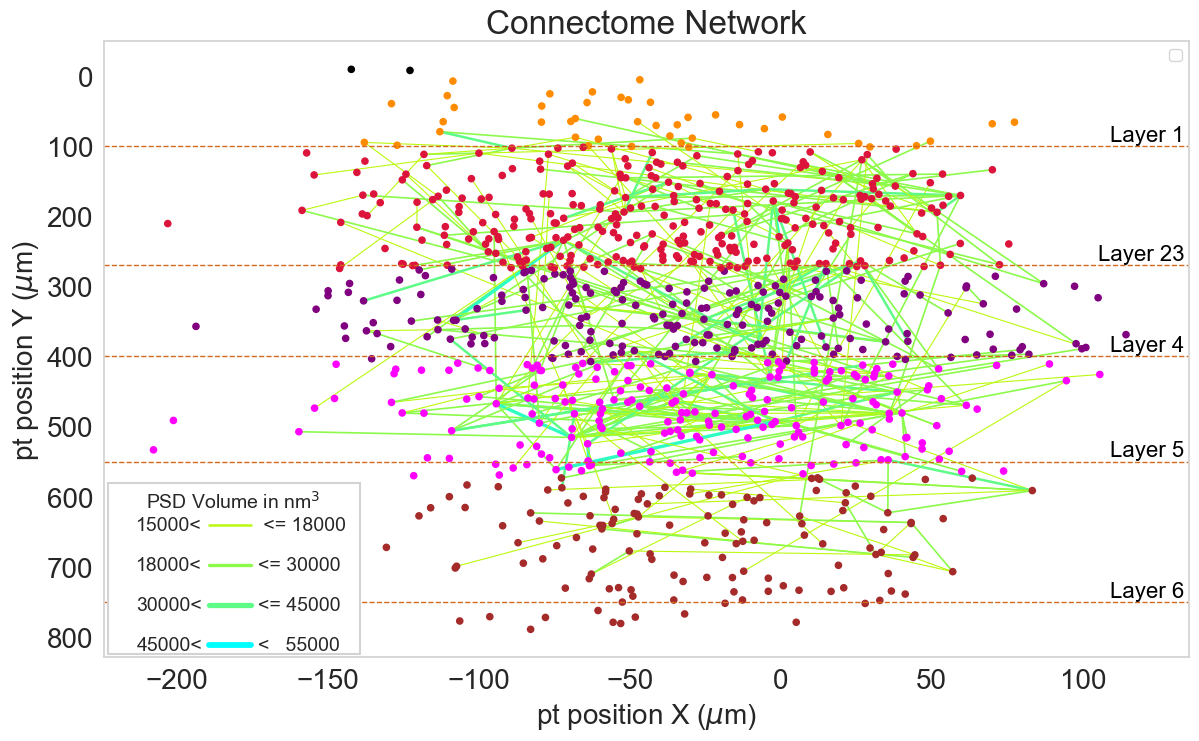

In [426]:

fig, ax = plt.subplots(figsize=(14,8))


nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=20,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis



#-------Add layers to plot----------
#y_values = [max_p2_l1, max_p2_l23,max_p2_l4,  max_p2_l5,  max_p2_l6]
y_values= [100, 270, 400,  550, 750]
labels = ['Layer 1', 'Layer 23', 'Layer 4', 'Layer 5', 'Layer 6']

ax = plt.gca()
offset = 1.5
# Add horizontal lines and labels
for y, label in zip(y_values, labels):
    ax.axhline(y=y, color='chocolate', linestyle='--', linewidth=1)
    #x = ax.get_x()
    x_min, x_max = ax.get_xlim()
    ax.text(x_max - offset,y - offset, label, color='black', fontsize=16, ha='right', va='bottom')

#---------------------------------



#node_legend.set_ed

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color=colorFader(c1, c2, 4/4), lw=4.2),
    Line2D([0], [0], color=colorFader(c1, c2, 2/4),lw=3.8),
    Line2D([0], [0], color=colorFader(c1, c2, 1/4),lw=2.4),
     Line2D([0], [0], color=colorFader(c1, c2, 0), lw=1.8)
]




#edge_legend = ax.legend(handles=edge_legend_elements, loc='lower left',title='Synapse Strength (PSD)',fontsize = 6.5,title_fontsize = 6.5)

    # Line2D([0], [0], color='yellow', label = '15000 < synapse strength <= 18000' ,  lw=0.5),
    # Line2D([0], [0], color='orange',label = '18000 < synapse strength <= 30000' ,lw=1),
    # Line2D([0], [0], color='cyan',label = '30000  < synapse strength <= 45000' ,lw=1.5),
    # Line2D([0], [0], color='m', label = '45000 < synapse strength', lw=2)


#Add the labels for edge legend
edge_labels = ['45000<  <   55000', '30000<  <= 45000', '18000<  <= 30000', '15000<   <= 18000' ]

### Create the edge legend - PSD Volume BOX ####

# Adjust the position for the bottom left corner (using figure coordinates)
x_coord = 0.18  # Value to move to the left(move horizontal)
y_coord = 0.125  # Value to adjust the distance from bottom
y_step_size = 0.05  # To maintain the vertical space between the four lines

title = (r"PSD Volume in nm$^{3}$")
fig.text(x_coord - 0.025 , y_coord + 0.18, title, fontsize=14, verticalalignment='center', horizontalalignment='left', fontweight='normal')

for i, (legend_element, label) in enumerate(zip(edge_legend_elements, edge_labels)):
    y_pos = y_coord + i * y_step_size
    
    #Using fig. instead of ax. allows it to align with the figure. Prevents the shrinking of the main figure.

    # Position text before the legend
    fig.text(x_coord + 0.015 , y_pos, label.split(' ')[0], fontsize=14, verticalalignment='center', horizontalalignment='right')
    
    # Position the legend element
    fig.add_artist(Line2D([x_coord + 0.02, x_coord + 0.05], [y_pos, y_pos], color=legend_element.get_color(), lw=legend_element.get_linewidth()))
    
    # Position text after the legend
    fig.text(x_coord + 0.055, y_pos, ' '.join(label.split(' ')[2:]), fontsize=14, verticalalignment='center', horizontalalignment='left')

#create the boundary box for edge legends
box_x = x_coord + 0.048 # add to move to right and subtract to move left
box_y = y_coord + 0.089 # add to move above the bottom
box_width = -0.02 # .000000000005 #adjust width of the box
box_height =0.014 #adjust the height of the box


box = FancyBboxPatch((box_x, box_y), box_width, box_height,
                     boxstyle="square,pad=0.1", edgecolor='lightgrey', facecolor='white', linewidth=1.5,
                     transform=fig.transFigure, zorder=1)
fig.patches.append(box)



#########trial method for text legend combo - did not work (use label.split() instead)#############
# ax.annotate('1: Conn 1: ', xy=(1.05, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),
# ax.annotate('-'*2, xy=(1.24, 0.9), xycoords='axes fraction', color='red', fontsize=12, ha='left', va='center'),
# ax.annotate('1: Conn 1: ', xy=(1.5, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),


# Show the plot

#add both node and edge legends
#ax.add_artist(node_legend)  # Add the node legend first
#ax.add_artist(edge_legend)

#invert axis to get Layer 6 at bottom
ax.invert_yaxis()
#ax.invert_xaxis()

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 20, pad = 8, length = 0)
ax.legend(markerfirst = False)
for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')  # Set the boundary color to gray
# Customize with Seaborn styles if needed
sns.set_theme(style="white") 

plt.xlabel(r'pt position X ($\mu$m)', fontsize = 20) 
plt.ylabel(r'pt position Y ($\mu$m)', fontsize = 20)
plt.title('Connectome Network', fontsize = 24)
plt.autoscale()
plt.savefig('connectivity_nodes_split_by_layers.png', dpi=1200) 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


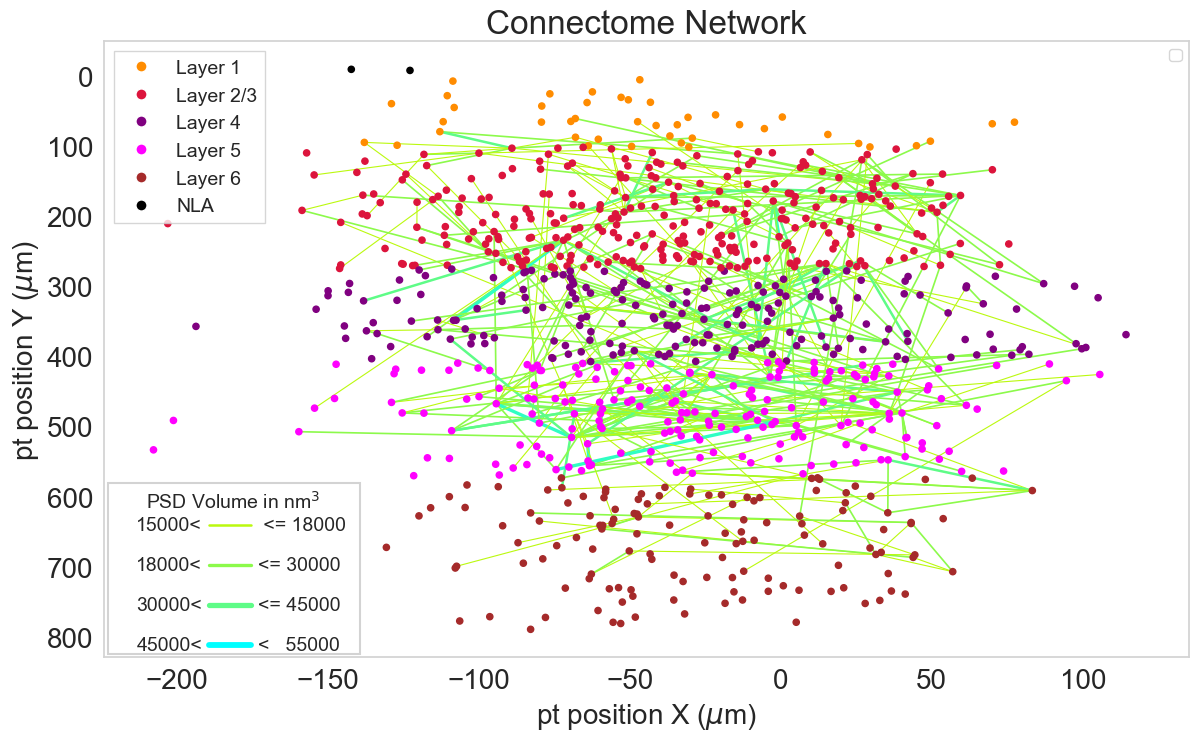

In [418]:




fig, ax = plt.subplots(figsize=(14,8))


nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=20,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis



#-------Add layers to plot----------
#y_values = [max_p2_l1, max_p2_l23,max_p2_l4,  max_p2_l5,  max_p2_l6]
y_values= [100, 270, 400,  550, 750]
labels = ['Layer 1', 'Layer 23', 'Layer 4', 'Layer 5', 'Layer 6']

ax = plt.gca()
offset = 1.5

#---------------------------------


# Create custom legend handles for nodes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markersize=8, label='Layer 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', markersize=8, label='Layer 2/3'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Layer 4'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=8, label='Layer 5'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=8, label='Layer 6'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='NLA')
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='gree', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='b', markersize=10, label='Non-assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='y', markersize=10, label='Assembly cells'),
    # Line2D([0], [0], marker='_', color='w', markerfacecolor='m', markersize=10, label='Non-assembly cells')
]

# Add the legend to the plot
node_legend = ax.legend(handles=legend_elements, loc='upper left', fontsize='14', fancybox = False)  #fancybox=false to prevent rounded corners
#node_legend.set_ed

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color=colorFader(c1, c2, 4/4), lw=4.2),
    Line2D([0], [0], color=colorFader(c1, c2, 2/4),lw=3.8),
    Line2D([0], [0], color=colorFader(c1, c2, 1/4),lw=2.4),
     Line2D([0], [0], color=colorFader(c1, c2, 0), lw=1.8)
]




#edge_legend = ax.legend(handles=edge_legend_elements, loc='lower left',title='Synapse Strength (PSD)',fontsize = 6.5,title_fontsize = 6.5)

    # Line2D([0], [0], color='yellow', label = '15000 < synapse strength <= 18000' ,  lw=0.5),
    # Line2D([0], [0], color='orange',label = '18000 < synapse strength <= 30000' ,lw=1),
    # Line2D([0], [0], color='cyan',label = '30000  < synapse strength <= 45000' ,lw=1.5),
    # Line2D([0], [0], color='m', label = '45000 < synapse strength', lw=2)


#Add the labels for edge legend
edge_labels = ['45000<  <   55000', '30000<  <= 45000', '18000<  <= 30000', '15000<   <= 18000' ]

### Create the edge legend - PSD Volume BOX ####

# Adjust the position for the bottom left corner (using figure coordinates)
x_coord = 0.18  # Value to move to the left(move horizontal)
y_coord = 0.125  # Value to adjust the distance from bottom
y_step_size = 0.05  # To maintain the vertical space between the four lines

title = (r"PSD Volume in nm$^{3}$")
fig.text(x_coord - 0.025 , y_coord + 0.18, title, fontsize=14, verticalalignment='center', horizontalalignment='left', fontweight='normal')

for i, (legend_element, label) in enumerate(zip(edge_legend_elements, edge_labels)):
    y_pos = y_coord + i * y_step_size
    
    #Using fig. instead of ax. allows it to align with the figure. Prevents the shrinking of the main figure.

    # Position text before the legend
    fig.text(x_coord + 0.015 , y_pos, label.split(' ')[0], fontsize=14, verticalalignment='center', horizontalalignment='right')
    
    # Position the legend element
    fig.add_artist(Line2D([x_coord + 0.02, x_coord + 0.05], [y_pos, y_pos], color=legend_element.get_color(), lw=legend_element.get_linewidth()))
    
    # Position text after the legend
    fig.text(x_coord + 0.055, y_pos, ' '.join(label.split(' ')[2:]), fontsize=14, verticalalignment='center', horizontalalignment='left')

#create the boundary box for edge legends
box_x = x_coord + 0.048 # add to move to right and subtract to move left
box_y = y_coord + 0.089 # add to move above the bottom
box_width = -0.02 # .000000000005 #adjust width of the box
box_height =0.014 #adjust the height of the box


box = FancyBboxPatch((box_x, box_y), box_width, box_height,
                     boxstyle="square,pad=0.1", edgecolor='lightgrey', facecolor='white', linewidth=1.5,
                     transform=fig.transFigure, zorder=1)
fig.patches.append(box)



#########trial method for text legend combo - did not work (use label.split() instead)#############
# ax.annotate('1: Conn 1: ', xy=(1.05, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),
# ax.annotate('-'*2, xy=(1.24, 0.9), xycoords='axes fraction', color='red', fontsize=12, ha='left', va='center'),
# ax.annotate('1: Conn 1: ', xy=(1.5, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),


# Show the plot

#add both node and edge legends
ax.add_artist(node_legend)  # Add the node legend first
#ax.add_artist(edge_legend)

#invert axis to get Layer 6 at bottom
ax.invert_yaxis()
#ax.invert_xaxis()

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 20, pad = 8, length = 0)
ax.legend(markerfirst = False)
for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')  # Set the boundary color to gray
# Customize with Seaborn styles if needed
sns.set_theme(style="white") 

plt.xlabel(r'pt position X ($\mu$m)', fontsize = 20) 
plt.ylabel(r'pt position Y ($\mu$m)', fontsize = 20)
plt.title('Connectome Network', fontsize = 24)
plt.autoscale()
plt.savefig('connectivity_plot_nodes_by_layers_no_bnd.png', dpi=1200) 
plt.show()

## Excitatory and Inhibitory

In [427]:
color_map = []
edge_color = []
assembly_map = []
idx = []
no_assembly = ['No A']
for node in G.nodes():
    # if cell_table['classification_system'][node] == 'excitatory':
        
    #             color_map.append('royalblue')
    if cell_table['classification_system'][node] == 'inhibitory':
                            #print(nik)
                            color_map.append('royalblue')
                            edge_color.append('none')

                            
            
            #idx.append(node)
    else:
            color_map.append('none')
            edge_color.append('grey')
    
    if node in  mappings['assemblies_by_connectome_index'].keys():
                   val = mappings['assemblies_by_connectome_index'][node]
                   if val == no_assembly:
                         
                          color_map[node] = 'maroon'
                         # edge_color.append('none')
                          #assembly_map.append('black')
                   else:
                            #print(nik)
                            color_map[node] = 'red'  
                           # edge_color.append('none')
 

  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


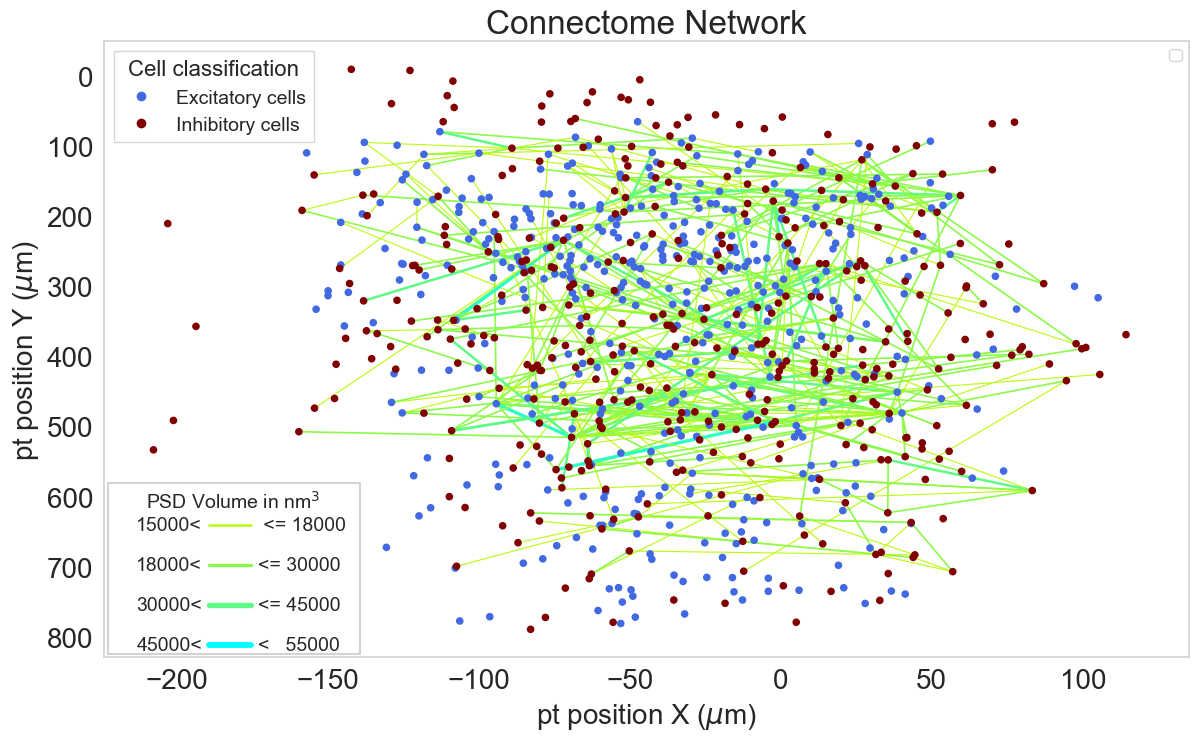

In [415]:


fig, ax = plt.subplots(figsize=(14,8))


nx.draw(G, pos,
        width=list(weights),
        edge_color=colors, 
        with_labels=False,node_size=20,
        node_color=color_map, ax= ax)
limits=plt.axis('on') # turns on axis



#-------Add layers to plot----------
#y_values = [max_p2_l1, max_p2_l23,max_p2_l4,  max_p2_l5,  max_p2_l6]
# y_values= [100, 270, 400,  550, 750]
# labels = ['Layer 1', 'Layer 23', 'Layer 4', 'Layer 5', 'Layer 6']

ax = plt.gca()
offset = 1.5
# # Add horizontal lines and labels
# for y, label in zip(y_values, labels):
#     ax.axhline(y=y, color='chocolate', linestyle='--', linewidth=1)
#     #x = ax.get_x()
#     x_min, x_max = ax.get_xlim()
#     ax.text(x_max - offset,y - offset, label, color='black', fontsize=16, ha='right', va='bottom')

#---------------------------------

# Create custom legend handles for nodes
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=8, label='Excitatory cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='maroon', markersize=8, label='Inhibitory cells'),
    
]

# Add the legend to the plot
node_legend = ax.legend(handles=legend_elements, loc='upper left', fontsize='14', fancybox = False, title = 'Cell classification', title_fontsize = 16)  #fancybox=false to prevent rounded corners
#node_legend.set_ed

# Create custom legend handles for edges
edge_legend_elements = [
    Line2D([0], [0], color=colorFader(c1, c2, 4/4), lw=4.2),
    Line2D([0], [0], color=colorFader(c1, c2, 2/4),lw=3.8),
    Line2D([0], [0], color=colorFader(c1, c2, 1/4),lw=2.4),
     Line2D([0], [0], color=colorFader(c1, c2, 0), lw=1.8)
]




#edge_legend = ax.legend(handles=edge_legend_elements, loc='lower left',title='Synapse Strength (PSD)',fontsize = 6.5,title_fontsize = 6.5)

    # Line2D([0], [0], color='yellow', label = '15000 < synapse strength <= 18000' ,  lw=0.5),
    # Line2D([0], [0], color='orange',label = '18000 < synapse strength <= 30000' ,lw=1),
    # Line2D([0], [0], color='cyan',label = '30000  < synapse strength <= 45000' ,lw=1.5),
    # Line2D([0], [0], color='m', label = '45000 < synapse strength', lw=2)


#Add the labels for edge legend
edge_labels = ['45000<  <   55000', '30000<  <= 45000', '18000<  <= 30000', '15000<   <= 18000' ]

### Create the edge legend - PSD Volume BOX ####

# Adjust the position for the bottom left corner (using figure coordinates)
x_coord = 0.18  # Value to move to the left(move horizontal)
y_coord = 0.125  # Value to adjust the distance from bottom
y_step_size = 0.05  # To maintain the vertical space between the four lines

title = (r"PSD Volume in nm$^{3}$")
fig.text(x_coord - 0.025 , y_coord + 0.18, title, fontsize=14, verticalalignment='center', horizontalalignment='left', fontweight='normal')

for i, (legend_element, label) in enumerate(zip(edge_legend_elements, edge_labels)):
    y_pos = y_coord + i * y_step_size
    
    #Using fig. instead of ax. allows it to align with the figure. Prevents the shrinking of the main figure.

    # Position text before the legend
    fig.text(x_coord + 0.015 , y_pos, label.split(' ')[0], fontsize=14, verticalalignment='center', horizontalalignment='right')
    
    # Position the legend element
    fig.add_artist(Line2D([x_coord + 0.02, x_coord + 0.05], [y_pos, y_pos], color=legend_element.get_color(), lw=legend_element.get_linewidth()))
    
    # Position text after the legend
    fig.text(x_coord + 0.055, y_pos, ' '.join(label.split(' ')[2:]), fontsize=14, verticalalignment='center', horizontalalignment='left')

#create the boundary box for edge legends
box_x = x_coord + 0.048 # add to move to right and subtract to move left
box_y = y_coord + 0.089 # add to move above the bottom
box_width = -0.02 # .000000000005 #adjust width of the box
box_height =0.014 #adjust the height of the box


box = FancyBboxPatch((box_x, box_y), box_width, box_height,
                     boxstyle="square,pad=0.1", edgecolor='lightgrey', facecolor='white', linewidth=1.5,
                     transform=fig.transFigure, zorder=1)
fig.patches.append(box)



#########trial method for text legend combo - did not work (use label.split() instead)#############
# ax.annotate('1: Conn 1: ', xy=(1.05, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),
# ax.annotate('-'*2, xy=(1.24, 0.9), xycoords='axes fraction', color='red', fontsize=12, ha='left', va='center'),
# ax.annotate('1: Conn 1: ', xy=(1.5, 0.9), xycoords='axes fraction', color='black', fontsize=12, ha='left', va='center'),


# Show the plot

#add both node and edge legends
ax.add_artist(node_legend)  # Add the node legend first
#ax.add_artist(edge_legend)

#invert axis to get Layer 6 at bottom
ax.invert_yaxis()
#ax.invert_xaxis()

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 20, pad = 8, length = 0)
ax.legend(markerfirst = False)
for spine in ax.spines.values():
    spine.set_edgecolor('lightgray')  # Set the boundary color to gray
# Customize with Seaborn styles if needed
sns.set_theme(style="white") 

plt.xlabel(r'pt position X ($\mu$m)', fontsize = 20) 
plt.ylabel(r'pt position Y ($\mu$m)', fontsize = 20)
plt.title('Connectome Network', fontsize = 24)
plt.autoscale()
#plt.savefig('connectivity_plot_nodes_split_by_exc_inh.png', dpi=1200) 
plt.show()

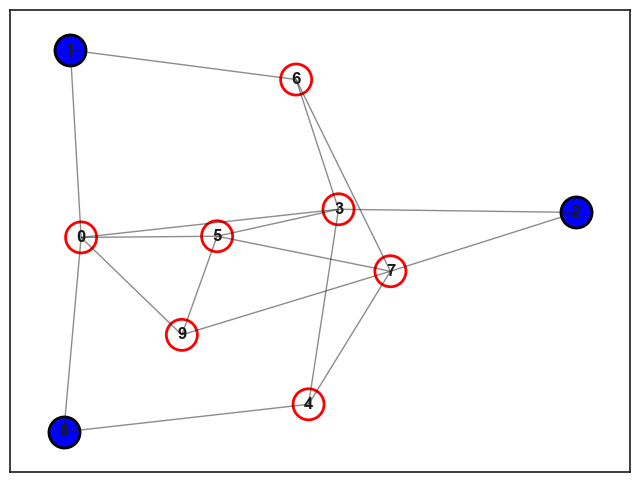

In [428]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample graph
G = nx.erdos_renyi_graph(10, 0.5)

# Define lists to store node colors and edgecolors
node_color = []
node_edgecolor = []

# Loop through all nodes to assign colors and edgecolors based on some condition
for node in G.nodes():
    if G.degree(node) > 2:  # Hollow nodes for high-degree nodes (example condition)
        node_color.append('none')  # Hollow node (transparent center)
        node_edgecolor.append('red')  # Red border for hollow nodes
    else:
        node_color.append('blue')  # Filled nodes with blue color
        node_edgecolor.append('black')  # Black border for filled nodes

# Get positions of the nodes
pos = nx.spring_layout(G)

# Create a plot
plt.figure(figsize=(8, 6))

# Draw the nodes with different border styles
for i, node in enumerate(G.nodes()):
    if node_color[i] == 'none':  # Hollow node
        plt.scatter(pos[node][0], pos[node][1], s=500, c='none', edgecolors=node_edgecolor[i], linewidths=2)
    else:  # Filled node
        plt.scatter(pos[node][0], pos[node][1], s=500, c=node_color[i], edgecolors=node_edgecolor[i], linewidths=2)

# Draw edges of the graph
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.show()


## Radial distance analysis

## Radial distance analysis

In [ ]:
##graph =  nx.from_numpy_array(tables['structural']['summed_size_connectome'].clip(0,1), create_using=nx.DiGraph)

In [379]:
x_pos = np.mean(cell_table['pt_position_x_trafo'])
y_pos = np.mean(cell_table['pt_position_y_trafo'])

cent_dist_no_a = []
cent_dist_a = []



In [380]:
x_pos, y_pos

(-34745.309390455724, 361853.0747079696)

In [381]:
import math 
for cell in mappings['assemblies_by_connectome_index']:
    if mappings['assemblies_by_connectome_index'][cell] == ['No A']:
        cent_dist_no_a.append([ np.linalg.norm(cell_table['pt_position_x_trafo'][cell] -  x_pos), np.linalg.norm(cell_table['pt_position_y_trafo'][cell] - y_pos)])
    else:
        cent_dist_a.append([np.linalg.norm(cell_table['pt_position_x_trafo'][cell] - x_pos), np.linalg.norm(cell_table['pt_position_y_trafo'][cell] -  y_pos)])

In [382]:
x_dist_no_a = [x[0] for x in cent_dist_no_a]
y_dist_no_a = [x[1] for x in cent_dist_no_a]
x_dist_a = [x1[0] for x1 in cent_dist_a]
y_dist_a = [x1[1] for x1 in cent_dist_a]

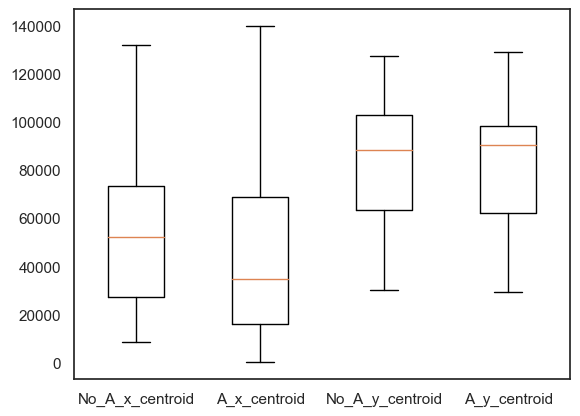

In [383]:
import scipy
plt.boxplot([x_dist_no_a, x_dist_a, y_dist_no_a, y_dist_a], labels= ['No_A_x_centroid', 'A_x_centroid', 'No_A_y_centroid', 'A_y_centroid'])

p_val, stats = scipy.stats.ranksums(x_dist_no_a, x_dist_a)
p_val_2, stats_2 = scipy.stats.ranksums(y_dist_no_a, y_dist_a)

In [384]:
x_dist_no_a, y_dist_no_a

([83989.52584452278,
  62950.19382635192,
  52050.244301381754,
  32040.419677837817,
  110877.8604064814,
  59553.05698701161,
  54518.579329200096,
  23970.89101477681,
  131995.51321112705,
  30405.260975593985,
  13684.586175444478,
  60336.04163600323,
  34875.04983457513,
  10507.248130808846,
  19653.420697607355,
  115097.84255102195,
  52093.447737768045,
  91439.85720927236,
  8566.717304283506],
 [127478.91760029539,
  121694.55513263898,
  114981.07988138738,
  120638.80267269287,
  92082.11068879586,
  108634.20919006004,
  88121.05550399492,
  97170.47963319649,
  61690.87600604963,
  88918.76456092641,
  89115.29443748883,
  73927.74756384746,
  74269.8277880667,
  65174.56889638782,
  52716.6853100757,
  48233.67689552641,
  41439.220019823,
  70621.63024788321,
  30163.16215157596])

In [377]:
y_dist_a

[119312.38792054172,
 105529.62785748084,
 121496.24080547376,
 129006.37133041085,
 107146.31882936528,
 112487.81565554152,
 98334.00343531632,
 105233.61169872893,
 105181.7256553463,
 98752.20520658413,
 110898.66036580989,
 104260.98666886921,
 97339.40308039525,
 102006.83594873353,
 93945.13279842975,
 96574.5900528701,
 93821.65333141154,
 75572.2533550036,
 97414.56415188347,
 83341.24380706658,
 53995.02515979344,
 45229.62544145819,
 82709.51194511814,
 50895.06304887246,
 58659.13686295075,
 76822.26403047645,
 62299.50542685314,
 77987.98604970949,
 49990.03110270394,
 53375.95976670098,
 53696.08269622002,
 52999.710685430386,
 29195.596142682305,
 68963.93952809292,
 52178.35659507534,
 75946.35334894148,
 96943.81307706208,
 89624.79333139409,
 92578.79516242328,
 93219.86002945568,
 82961.98785355827,
 103630.57685576411,
 115558.09139805852,
 68847.68291366659,
 45334.057616052625,
 98291.5705340092,
 83050.64058577112,
 95082.87856992614,
 42438.98868134996,
 97126.3

In [308]:
np.linalg.norm(-50 - (-34))

16.0